# Urban Flood Vulnerability Assessment - Colombo District, Sri Lanka

**Assignment 2 - Scientific Programming for Geospatial Sciences**

**Authors:** Surya Jamuna Rani Subramaniyan (S3664414) & Sachin Ravi (S3563545)

---

## Contents

0. **Setup & Data Download** - Automated data acquisition from public sources
1. **Data Loading** - Load real datasets (DEM, CHIRPS, Buildings, Water bodies)
2. **NumPy Array Operations** - Raster processing and masking
3. **PyTorch Tensor Operations** - GPU-aware spatial filtering and performance comparison
4. **Vector Processing** - GeoPandas/Shapely operations (3+ operations)
5. **Xarray Data Cubes** - Multi-temporal rainfall analysis
6. **Raster-Vector Integration** - Bidirectional raster-vector operations
7. **Advanced Analysis** - Hydrological proximity and vulnerability assessment
8. **Visualization & Results** - Maps and vulnerability classification

---

**Study Area:** Colombo District, Sri Lanka  
**Bounding Box:** 79.82°E - 80.22°E, 6.75°N - 7.05°N  
**Raster Resolution:** 0.05° (CHIRPS), 90m (SRTM), 30m (derived)  
**Vector Data:** OpenStreetMap buildings and administrative boundaries

**Quick run (student note):**
1. `conda activate geoai` and select that kernel.
2. Run all cells. Downloads will skip if data already present.
3. Key outputs land in `outputs/` (maps/raster tifs).
4. If a download fails but the file exists, just continue.


## 0. Setup & Data Download

Run this section once to download all required datasets automatically.  
**No API keys required!**

In [1]:
# Core imports
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import torch
import matplotlib.pyplot as plt
import requests
import json
import gzip
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Our modules
import sys
sys.path.append('..')
from src import data_loading, raster_analysis, tensor_operations, vector_analysis, integration, visualization



In [2]:
# Study area configuration
COLOMBO_BBOX = {
    'west': 79.82,
    'east': 80.22,
    'south': 6.75,
    'north': 7.05
}

# Paths
DATA_DIR = Path('../data')
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'
OUTPUT_DIR = Path('../outputs')

# Create directories
for d in [RAW_DIR / 'chirps', RAW_DIR / 'srtm', RAW_DIR / 'admin', 
          RAW_DIR / 'buildings', PROCESSED_DIR, OUTPUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)



In [3]:
# Helper function for downloads
def download_file(url, output_path, timeout=120):
    """Download a file with progress indication."""
    if output_path.exists():
        print(f"  Already exists: {output_path.name}")
        return True
    
    try:
        print(f"  Downloading: {output_path.name}...")
        response = requests.get(url, stream=True, timeout=timeout)
        response.raise_for_status()
        
        total_size = int(response.headers.get('content-length', 0))
        downloaded = 0
        
        with open(output_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
                downloaded += len(chunk)
                if total_size > 0:
                    pct = (downloaded / total_size) * 100
                    print(f"\r  Downloading: {output_path.name}... {pct:.1f}%", end='', flush=True)
        
        print(f"\n  Saved: {output_path.name}")
        return True
    except Exception as e:
        print(f"  Error: {e}")
        return False

### 0.1 Download SRTM DEM from AWS

In [4]:
# Download SRTM tiles from AWS Open Data
print("Downloading SRTM DEM from AWS...")

# Get required tiles for Colombo
srtm_tiles = ['N06E079', 'N06E080', 'N07E079', 'N07E080']
base_url = "https://elevation-tiles-prod.s3.amazonaws.com/skadi"

dem_files = []
for tile in srtm_tiles:
    lat_dir = tile[:3]
    filename = f"{tile}.hgt.gz"
    url = f"{base_url}/{lat_dir}/{filename}"
    output_path = RAW_DIR / 'srtm' / filename
    
    if output_path.exists():
        print(f"  Already exists: {filename}")
        dem_files.append(output_path)
    else:
        if download_file(url, output_path, timeout=120):
            dem_files.append(output_path)

print(f"\nDownloaded {len(dem_files)} DEM tiles")

  Already exists: N06E079.hgt.gz
  Already exists: N06E080.hgt.gz
  Already exists: N07E079.hgt.gz
  Already exists: N07E080.hgt.gz

Downloaded 4 DEM tiles


### 0.2 Download CHIRPS 2025 Monthly Rainfall Data

In [5]:
# Download CHIRPS 2025 monthly rainfall data (~40 MB)
print("Downloading CHIRPS 2025 monthly rainfall data...")

chirps_url = "https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_monthly/netcdf/byYear/chirps-v2.0.2025.monthly.nc"
chirps_path = RAW_DIR / 'chirps' / 'chirps-v2.0.2025.monthly.nc'

download_file(chirps_url, chirps_path, timeout=300)

  Already exists: chirps-v2.0.2025.monthly.nc


True

In [6]:
# Download Colombo District boundary using Nominatim (returns standard GeoJSON)
print("Downloading admin boundaries from Nominatim...")

admin_path = RAW_DIR / 'admin' / 'colombo_boundary.json'

# Delete existing file if it might be the wrong format (Overpass JSON)
if admin_path.exists():
    # We'll check if it's valid GeoJSON by trying to read it, or just overwrite to be safe given the error history
    try:
        gpd.read_file(admin_path)
        print(f"  Valid file already exists: {admin_path.name}")
    except:
        print("  Found invalid/incompatible file. Re-downloading...")
        admin_path.unlink()

if not admin_path.exists():
    # Use Nominatim API for clean GeoJSON
    url = "https://nominatim.openstreetmap.org/search"
    headers = {'User-Agent': 'UrbanFloodAnalysis/1.0 (Student Project)'}
    params = {
        'q': 'Colombo District, Sri Lanka',
        'format': 'geojson',
        'polygon_geojson': 1,
        'limit': 1
    }
    
    try:
        response = requests.get(url, params=params, headers=headers, timeout=30)
        response.raise_for_status()
        data = response.json()
        
        if not data.get('features'):
            print("  Warning: No features found from Nominatim.")
        else:
            with open(admin_path, 'w') as f:
                json.dump(data, f)
            print(f"  Saved: {admin_path.name}")
            
    except Exception as e:
        print(f"  Error: {e}")

# Load into memory for masking
if admin_path.exists():
    try:
        district_mask = gpd.read_file(admin_path)
        # Ensure it's a Polygon/MultiPolygon
        district_mask = district_mask.dissolve()
        print(f"District mask loaded: {district_mask.geometry.type[0]}")
    except Exception as e:
        print(f"Failed to load district mask: {e}")

  Valid file already exists: colombo_boundary.json
District mask loaded: Polygon


In [7]:
# Download OSM buildings (this may take 5-10 minutes for urban areas)
print("Downloading building footprints from OpenStreetMap...")

buildings_path = RAW_DIR / 'buildings' / 'osm_buildings.json'

if not buildings_path.exists():
    overpass_url = "https://overpass-api.de/api/interpreter"
    
    # Query for buildings in Colombo BBox
    buildings_query = f"""
    [out:json][timeout:300];
    (
      way["building"]({COLOMBO_BBOX['south']},{COLOMBO_BBOX['west']},{COLOMBO_BBOX['north']},{COLOMBO_BBOX['east']});
    );
    out geom;
    """
    
    try:
        response = requests.post(overpass_url, data={'data': buildings_query}, timeout=600)
        response.raise_for_status()
        data = response.json()
        
        with open(buildings_path, 'w') as f:
            json.dump(data, f)
        
        print(f"  Saved: {buildings_path.name}")
        print(f"  Found {len(data.get('elements', []))} building elements")
    except Exception as e:
        print(f"  Error: {e}")
else:
    print(f"  Already exists: {buildings_path.name}")

  Already exists: osm_buildings.json


In [8]:
# Download OSM roads (real data)
print("Downloading road network from OpenStreetMap...")
roads_path = RAW_DIR / 'roads' / 'osm_roads.json'
roads = data_loading.download_osm_roads(
    COLOMBO_BBOX, roads_path,
    highway_types=['motorway','trunk','primary','secondary','tertiary','residential','service']
)
print(f"Saved: {roads_path.name} with {len(roads)} segments")


Requesting roads from Overpass API...
  Trying Overpass mirror: https://overpass-api.de/api/interpreter (Attempt 1/3)...
Downloaded raw roads to ..\data\raw\roads\osm_roads.json
Saved: osm_roads.json with 37555 segments


### 0.5 Preview Buildings on Map

In [9]:
# Load and Clip OSM Buildings
print("Loading OSM Buildings...")
osm_buildings_file = RAW_DIR / 'buildings' / 'osm_buildings.json'

if osm_buildings_file.exists():
    buildings = data_loading.load_osm_buildings(osm_buildings_file)
    
    # Clip to District (Masking requirement)
    # Check if district_mask is available (defined in earlier cell)
    if 'district_mask' in locals():
        try:
            print("Clipping buildings to district boundary...")
            buildings = vector_analysis.clip_vectors_to_boundary(buildings, district_mask)
        except Exception as e:
            print(f"Clipping failed: {e}")
    
    print(f"Loaded {len(buildings)} buildings")
else:
    print("OSM Buildings file not found. Please run Section 0.4.")

Loading OSM Buildings...
Clipping buildings to district boundary...
Loaded 231557 buildings


### 0.5 Data Status Check

In [10]:
# Check what data we have
print("DATA STATUS")
print("=" * 50)

# DEM
dem_files_found = list((RAW_DIR / 'srtm').glob('*.tif')) + list((RAW_DIR / 'srtm').glob('*.zip'))
print(f"SRTM Data:      Found" if dem_files_found else "SRTM Data:      Not found")

# Admin boundaries
admin_files = list((RAW_DIR / 'admin').glob('*.json'))
print(f"Admin boundary: Found" if admin_files else "Admin boundary: Not found")

# CHIRPS
chirps_files = list((RAW_DIR / 'chirps').glob('*.nc'))
print(f"CHIRPS data:    Found ({chirps_files[0].name})" if chirps_files else "CHIRPS data:    Not found")

# Buildings
building_files = list((RAW_DIR / 'buildings').glob('*.json'))
print(f"Buildings:      Found" if building_files else "Buildings:      Not found")

print("=" * 50)

DATA STATUS
SRTM Data:      Found
Admin boundary: Found
CHIRPS data:    Found (chirps-v2.0.2025.monthly.nc)
Buildings:      Found


---

## 1. Data Loading

Load the real datasets for analysis.

In [11]:
# Ensure District Mask is Loaded (Resilience Check)
# This ensures the mask is available even if Section 0 was skipped
if 'district_mask' not in locals():
    admin_path = RAW_DIR / 'admin' / 'colombo_boundary.json'
    if admin_path.exists():
        try:
            print("Loading district mask from disk...")
            district_mask = gpd.read_file(admin_path).dissolve()
            print("District mask loaded successfully.")
        except Exception as e:
            print(f"Error loading district mask: {e}")
    else:
        print("Warning: District boundary file not found. Visualizations may not be masked.")
else:
    print("District mask is already loaded.")

District mask is already loaded.


Elevation data loaded and masked: (1, 288, 217)


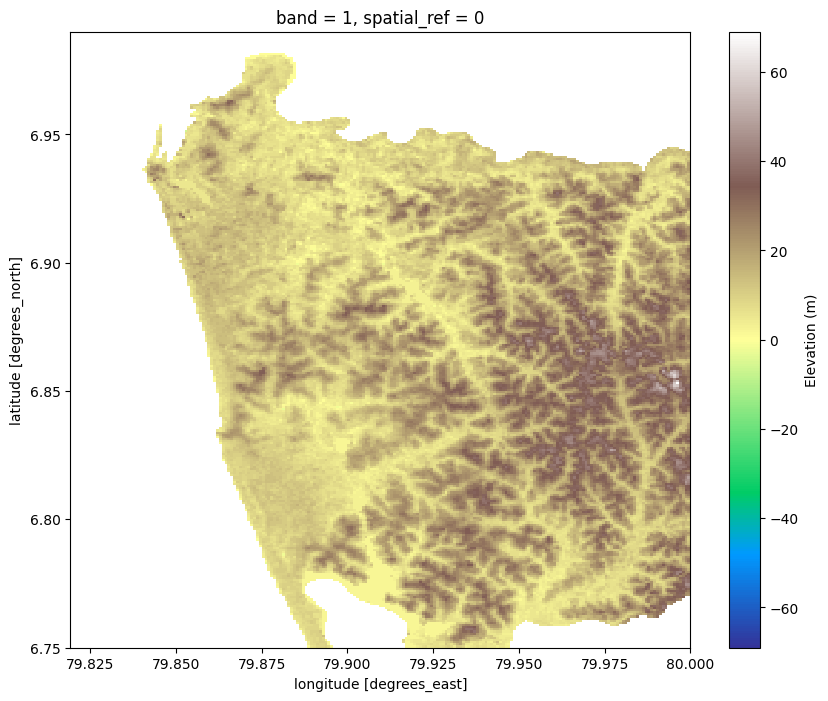

In [12]:
# Mask Elevation with District Boundary
elevation = data_loading.download_srtm(COLOMBO_BBOX, cache_dir=RAW_DIR / 'srtm')

# Apply Mask
elevation = raster_analysis.mask_raster_with_vector(elevation, district_mask)

print(f"Elevation data loaded and masked: {elevation.shape}")
elevation.plot(cmap='terrain', figsize=(10, 8), cbar_kwargs={'label': 'Elevation (m)'})

In [13]:
# Load CHIRPS 2025 rainfall data and clip to study area
print("Loading CHIRPS 2025 monthly rainfall data...")

chirps_file = RAW_DIR / 'chirps' / 'chirps-v2.0.2025.monthly.nc'

if chirps_file.exists():
    # Load full dataset
    ds = xr.open_dataset(chirps_file)
    
    # Get the precipitation variable and clip to BBOX first
    # Slice latitude (handle both ascending and descending cases)
    rainfall_cube = ds['precip'].sel(
        latitude=slice(COLOMBO_BBOX['south'], COLOMBO_BBOX['north']),
        longitude=slice(COLOMBO_BBOX['west'], COLOMBO_BBOX['east'])
    )
    if rainfall_cube.size == 0:
       rainfall_cube = ds['precip'].sel(
          latitude=slice(COLOMBO_BBOX['north'], COLOMBO_BBOX['south']),
          longitude=slice(COLOMBO_BBOX['west'], COLOMBO_BBOX['east'])
       )

        # Assign CRS explicitely before masking (Critical Fix)
    rainfall_cube.rio.write_crs("EPSG:4326", inplace=True)

    # Apply District Mask
    try:
        rainfall_cube = raster_analysis.mask_raster_with_vector(rainfall_cube, district_mask)
        print(f"Rainfall data loaded and masked: {rainfall_cube.shape}")
    except Exception as e:
        print(f"Warning: Masking failed ({e}), using rectangular clip")
    
else:
    print("CHIRPS file not found")

Loading CHIRPS 2025 monthly rainfall data...
Rainfall data loaded and masked: (12, 5, 8)


In [14]:
# Load and Clip OSM Buildings
print("Loading OSM Buildings...")
osm_buildings_file = RAW_DIR / 'buildings' / 'osm_buildings.json'

if osm_buildings_file.exists():
    buildings = data_loading.load_osm_buildings(osm_buildings_file)
    
    # Clip to District (Masking requirement)
    # Check if district_mask is available (defined in earlier cell)
    if 'district_mask' in locals():
        try:
            print("Clipping buildings to district boundary...")
            buildings = vector_analysis.clip_vectors_to_boundary(buildings, district_mask)
        except Exception as e:
            print(f"Clipping failed: {e}")
    
    print(f"Loaded {len(buildings)} buildings")
else:
    print("OSM Buildings file not found. Please run Section 0.4.")

Loading OSM Buildings...
Clipping buildings to district boundary...
Loaded 231557 buildings


In [15]:
# Download Real Admin Boundaries (Level 9 - Wards) & Parse Resiliently
from shapely.geometry import LineString, Polygon, MultiPolygon
from shapely.ops import linemerge, unary_union
import warnings

print("Downloading Admin Level 9 Wards and parsing geometry...")

ds_path = RAW_DIR / 'admin' / 'colombo_wards.json'
admin_boundaries = gpd.GeoDataFrame() # Initialize as empty

def parse_overpass_relation_to_poly(element):
    try:
        segments = []
        for member in element.get('members', []):
            if member['type'] == 'way' and 'geometry' in member:
                coords = [(pt['lon'], pt['lat']) for pt in member['geometry']]
                if len(coords) >= 2:
                    segments.append(LineString(coords))
        
        if not segments:
            return None
        merged = linemerge(segments)
        if merged.is_closed and not merged.is_empty:
             return Polygon(merged)
        elif hasattr(merged, 'geoms'):
             from shapely.ops import polygonize
             polys = list(polygonize(merged))
             if len(polys) == 1:
                 return polys[0]
             elif len(polys) > 1:
                 return MultiPolygon(polys)
        return None
    except:
        return None

# Ensure directory exists
ds_path.parent.mkdir(parents=True, exist_ok=True)

# Download/Parse
try:
    # Try loading existing first
    if ds_path.exists():
        try:
            print(f"  Attempting to load existing file: {ds_path.name}")
            admin_boundaries = gpd.read_file(ds_path)
            if not admin_boundaries.empty:
                print(f"  Loaded {len(admin_boundaries)} wards from disk.")
                # Ensure ds_id exists
                if 'ds_id' not in admin_boundaries.columns:
                     admin_boundaries['ds_id'] = [f"W{i:02d}" for i in range(len(admin_boundaries))]
        except Exception as e:
            print(f"  Error reading existing file: {e}")
            admin_boundaries = gpd.GeoDataFrame() # Reset on failure

    # If empty or not exists, DOWNLOAD
    if admin_boundaries.empty:
        print("  Downloading from Overpass API...")
        overpass_url = "https://overpass-api.de/api/interpreter"
        ds_query = f'''
        [out:json][timeout:180];
        (
          relation["admin_level"="9"]({COLOMBO_BBOX['south']},{COLOMBO_BBOX['west']},{COLOMBO_BBOX['north']},{COLOMBO_BBOX['east']});
        );
        out geom;
        '''
        response = requests.post(overpass_url, data={'data': ds_query}, timeout=300)
        response.raise_for_status()
        raw_data = response.json()
        
        features = []
        for el in raw_data.get('elements', []):
            if el['type'] == 'relation':
                geom = parse_overpass_relation_to_poly(el)
                if geom:
                    tags = el.get('tags', {})
                    feat = tags.copy()
                    feat['geometry'] = geom
                    feat['id'] = el['id']
                    features.append(feat)
        
        if features:
            admin_boundaries = gpd.GeoDataFrame(features, crs="EPSG:4326")
            if 'ds_id' not in admin_boundaries.columns:
                admin_boundaries['ds_id'] = [f"W{i:02d}" for i in range(len(admin_boundaries))]
            if 'ds_name' not in admin_boundaries.columns:
                admin_boundaries['ds_name'] = admin_boundaries.get('name', 'Unknown')
            
            # Save
            admin_boundaries.to_file(ds_path, driver="GeoJSON")
            print(f"  Successfully saved {len(admin_boundaries)} Wards.")
        else:
            print("  Warning: No features found.")

except Exception as e:
    print(f"Error in admin data logic: {e}")

# Fallback
if admin_boundaries.empty:
     print("  Creating empty fallback.")
     admin_boundaries = gpd.GeoDataFrame(columns=['ds_id', 'ds_name', 'geometry'], crs="EPSG:4326")

# Final Checks
if 'ds_id' not in admin_boundaries.columns:
    admin_boundaries['ds_id'] = [f"W{i:02d}" for i in range(len(admin_boundaries))]
    
# Create Mask
if not admin_boundaries.empty:
    district_mask = gpd.GeoDataFrame({'geometry': [admin_boundaries.unary_union]}, crs=admin_boundaries.crs)
else:
    print("Warning: Admin empty. Visualizations compromised.")


  Attempting to load existing file: colombo_wards.json
  Loaded 37 wards from disk.


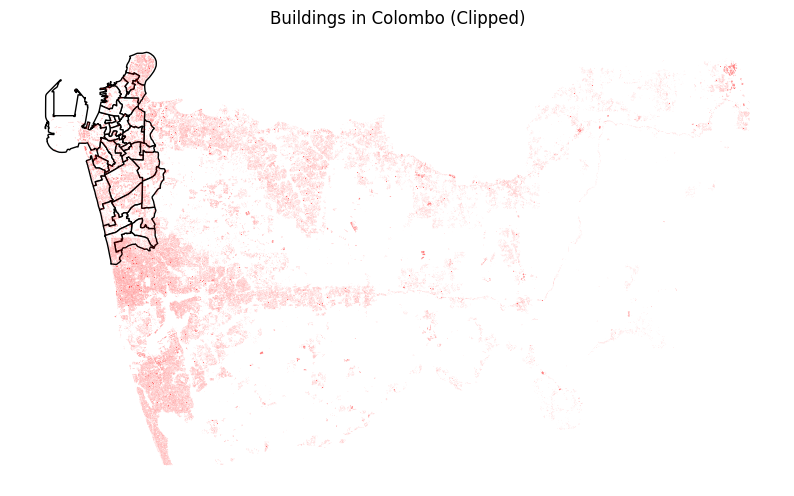

In [16]:
# Plot (Fixed)
try:
    if 'admin_boundaries' in locals() and not admin_boundaries.empty:
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Check if admin boundaries have valid geometry
        # This prevents 'aspect must be finite' error in geopandas/matplotlib
        valid_admin = admin_boundaries[~admin_boundaries.geometry.is_empty & admin_boundaries.geometry.is_valid]
        if not valid_admin.empty:
            try:
                valid_admin.plot(ax=ax, color='white', edgecolor='black')
            except Exception as e:
                print(f"Warning: Could not plot admin boundaries: {e}")
        else:
             print("Warning: admin_boundaries has no valid/non-empty geometries to plot.")
        
        if 'osm_buildings_file' in locals() and osm_buildings_file.exists() and 'buildings' in locals() and not buildings.empty:
            valid_buildings = buildings[~buildings.geometry.is_empty & buildings.geometry.is_valid]
            if not valid_buildings.empty:
                try:
                    valid_buildings.plot(ax=ax, markersize=1, color='red', alpha=0.5)
                except Exception as e:
                    print(f"Warning: Could not plot buildings: {e}")
            else:
                print("Warning: Buildings dataframe has no valid/non-empty geometries.")
            
        ax.set_title("Buildings in Colombo (Clipped)")
        ax.set_axis_off()
        plt.show()
    else:
        print("Skipping plot: admin_boundaries not available or empty.")
except Exception as e:
    print(f"Plotting completely failed: {e}")


---

## 2. NumPy Array Operations

Array-based raster processing using real data.

In [17]:
# Get rainfall as numpy array
rainfall_np = rainfall_cube.values
print(f"Rainfall array shape: {rainfall_np.shape} (months, lat, lon)")

# Calculate max monthly rainfall for usage in operations
max_monthly_rainfall = rainfall_cube.max(dim='time')
print(f"Max monthly rainfall range: {float(max_monthly_rainfall.min()):.1f} - {float(max_monthly_rainfall.max()):.1f} mm")

Rainfall array shape: (12, 5, 8) (months, lat, lon)
Max monthly rainfall range: 524.1 - 709.2 mm


In [18]:
# Create high rainfall mask (>300mm/month threshold)
high_rainfall_mask = rainfall_np > 300
print(f"High rainfall events (>300mm/month): {high_rainfall_mask.sum()} grid-months")

High rainfall events (>300mm/month): 199 grid-months


Text(0.5, 1.0, 'Max Monthly Rainfall (Masked)')

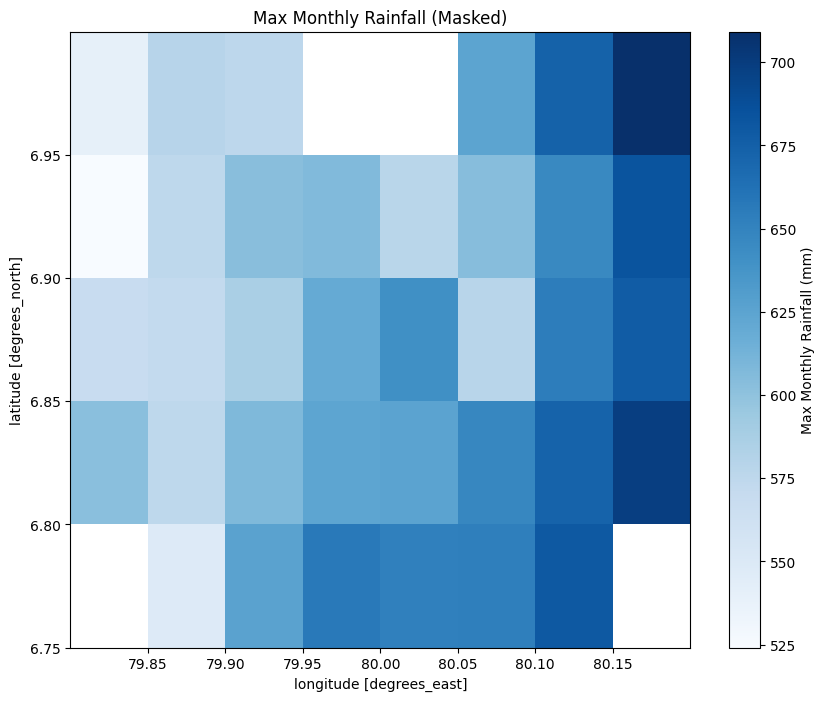

In [19]:
max_monthly_rainfall.plot(cmap='Blues', figsize=(10, 8), cbar_kwargs={'label': 'Max Monthly Rainfall (mm)'})
plt.title('Max Monthly Rainfall (Masked)')

In [20]:
# Calculate mean annual rainfall
mean_annual = np.nanmean(rainfall_np, axis=0) * 12  # Convert to annual
print(f"Estimated annual rainfall: {np.nanmean(mean_annual):.0f} mm/year")

Estimated annual rainfall: 3587 mm/year


In [21]:
# Normalize for vulnerability calculation
rainfall_norm = raster_analysis.normalize_array(max_monthly_rainfall, method='minmax')
elev_values = elevation.values
elev_values = np.nan_to_num(elev_values, nan=np.nanmean(elev_values))
elevation_norm = raster_analysis.normalize_array(elev_values, method='minmax')

print(f"Normalized rainfall range: {np.nanmin(rainfall_norm):.3f} - {np.nanmax(rainfall_norm):.3f}")
print(f"Normalized elevation range: {np.nanmin(elevation_norm):.3f} - {np.nanmax(elevation_norm):.3f}")

Normalized rainfall range: 0.000 - 1.000
Normalized elevation range: 0.000 - 1.000


---

## 3. PyTorch Tensor Operations

Demonstrating GPU-aware spatial filtering and performance comparison with NumPy.

In [22]:
# Check GPU availability
tensor_operations.print_gpu_info()

Device Information
CUDA available: No
Apple MPS available: No
PyTorch version: 2.10.0+cpu


In [23]:
# Convert to tensor
rainfall_tensor = tensor_operations.numpy_to_tensor(max_monthly_rainfall, device='auto')
print(f"Tensor device: {rainfall_tensor.device}")
print(f"Tensor shape: {rainfall_tensor.shape}")

Tensor device: cpu
Tensor shape: torch.Size([5, 8])


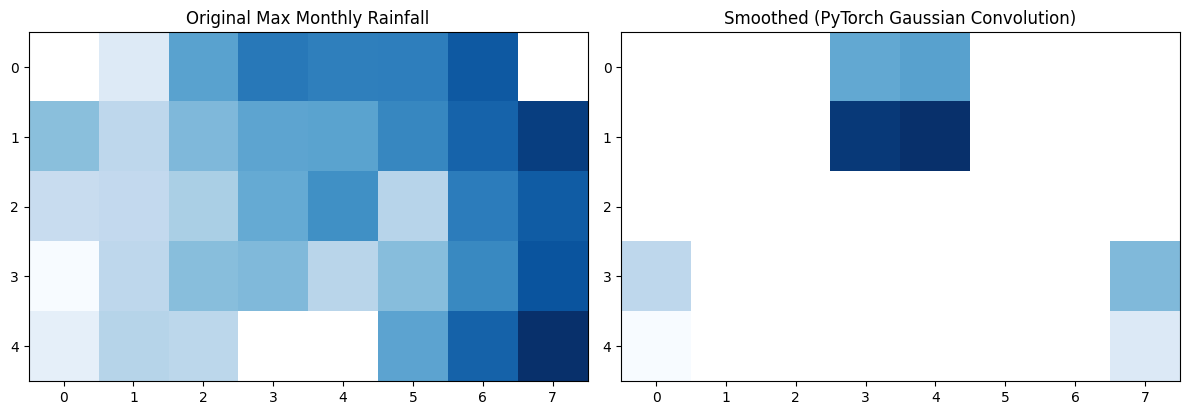

In [24]:
# Apply Gaussian convolution for spatial smoothing
smoothed_tensor = tensor_operations.apply_gaussian_convolution(
    rainfall_tensor, kernel_size=5, sigma=1.5
)

# Convert back to numpy for visualization
smoothed = tensor_operations.tensor_to_numpy(smoothed_tensor)

# Compare
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(max_monthly_rainfall, cmap='Blues', origin='upper')
axes[0].set_title('Original Max Monthly Rainfall')
axes[1].imshow(smoothed, cmap='Blues', origin='upper')
axes[1].set_title('Smoothed (PyTorch Gaussian Convolution)')
plt.tight_layout()
plt.show()

In [25]:
# PERFORMANCE COMPARISON: NumPy vs PyTorch
print("Running performance comparison...")
print("(Measuring Gaussian convolution speed)\n")

perf_results = tensor_operations.compare_numpy_vs_torch(
    max_monthly_rainfall, kernel_size=5, sigma=1.5, num_iterations=10
)

print("=" * 55)
print("        PERFORMANCE COMPARISON RESULTS")
print("=" * 55)
print(f"Array size:        {max_monthly_rainfall.shape}")
print(f"Operation:         5x5 Gaussian Convolution")
print(f"Iterations:        10")
print("")
print(f"NumPy (scipy):     {perf_results['numpy_time']*1000:.2f} ms +/- {perf_results['numpy_std']*1000:.2f} ms")
print(f"PyTorch ({perf_results['device']:6s}):  {perf_results['torch_time']*1000:.2f} ms +/- {perf_results['torch_std']*1000:.2f} ms")
print("")
print(f"Speedup:           {perf_results['speedup']:.2f}x")
print("=" * 55)

Running performance comparison...
(Measuring Gaussian convolution speed)

        PERFORMANCE COMPARISON RESULTS
Array size:        (5, 8)
Operation:         5x5 Gaussian Convolution
Iterations:        10

NumPy (scipy):     0.86 ms +/- 2.40 ms
PyTorch (cpu   ):  0.27 ms +/- 0.13 ms

Speedup:           3.20x


In [26]:
# Load OSM roads
roads_file = RAW_DIR / 'roads' / 'osm_roads.json'
roads = gpd.GeoDataFrame()
if roads_file.exists():
    roads = data_loading.load_osm_roads(roads_file, road_types=['motorway','trunk','primary','secondary','tertiary','residential','service'])
    print(f"Loaded roads: {len(roads)} segments")
else:
    print('Roads file not found; please run the download cell above.')


Loaded roads: 37086 segments


---

## 4. Vector Processing (GeoPandas/Shapely)

At least 3 vector operations as required.

In [27]:
# Spatial Join - assign DS to each building
buildings_joined = vector_analysis.spatial_join_buildings_to_admin(
    buildings, admin_boundaries, admin_id_col='ds_id'
)

print("OPERATION 1: Spatial Join")
print(f"   Buildings with DS assignment: {len(buildings_joined)}")
print(buildings_joined[['building_id', 'ds_id']].head())

OPERATION 1: Spatial Join
   Buildings with DS assignment: 231557
   building_id ds_id
0     52563172   W26
1     73142836   NaN
2     83981058   W24
3     83981239   NaN
5     98046408   W12


In [28]:
# Building Density Calculation
admin_with_density = vector_analysis.calculate_building_density(
    buildings, admin_boundaries, admin_id_col='ds_id'
)

print("OPERATION 2: Building Density Calculation")
print(admin_with_density[['ds_name', 'building_count', 'density_per_sqkm']])

OPERATION 2: Building Density Calculation
             ds_name  building_count  density_per_sqkm
0       AluthMawatha             177        277.062940
1        Bloemendhal             325        312.143267
2        Gintupitiya              21        105.293117
3       Lunupokurana             240        203.538421
4          Mahawatte            1344       1450.959188
5       Mattakkuliya            3844       1533.019446
6             Modera            1115       1675.671298
7          Grandpass            1265       1174.854118
8    Masangasweediya              22         81.878528
9          NewBazzar              13         25.366488
10         Aluthkade              78        183.828008
11       Kochchikade              62         78.463831
12              Fort             845        106.703227
13        Hunupitiya             228        297.221821
14          Maradana             132        503.839293
15         Suduwella             347        279.342338
16          Weekanda   

Total buffered road area: 2722.08 sqkm


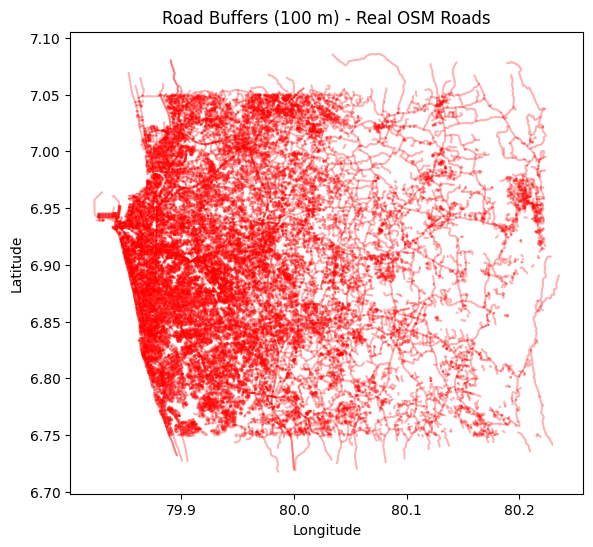

In [29]:
# Buffer analysis using real roads (100 m)
if roads.empty:
    print('Roads data unavailable; skipping road buffer analysis.')
else:
    roads_utm = roads.to_crs('EPSG:32644')
    road_buffers = roads_utm.buffer(100)  # 100 m buffer
    buffer_area = road_buffers.area.sum() / 1e6
    print(f'Total buffered road area: {buffer_area:.2f} sqkm')
    # Back to WGS84 for plotting
    road_buffers_wgs = road_buffers.to_crs('EPSG:4326')
    gpd.GeoSeries(road_buffers_wgs).plot(figsize=(8,6), color='red', alpha=0.3)
    plt.title('Road Buffers (100 m) - Real OSM Roads')
    plt.xlabel('Longitude'); plt.ylabel('Latitude')
    plt.show()


---

## 5. Xarray Data Cubes

Multi-temporal analysis using CHIRPS 2025 rainfall data as a spatio-temporal data cube.

In [30]:
# Show data cube structure
print("Rainfall Data Cube Structure:")
print(rainfall_cube)

Rainfall Data Cube Structure:
<xarray.DataArray 'precip' (time: 12, latitude: 5, longitude: 8)>
array([[[       nan, 135.39539 , 157.41713 , 178.27838 , 193.43811 ,
         201.75034 , 223.26375 ,        nan],
        [176.67807 , 161.66776 , 160.04404 , 186.31367 , 201.75209 ,
         202.5744  , 219.41289 , 247.25534 ],
        [184.83278 , 162.71884 , 149.4261  , 195.72748 , 222.47763 ,
         244.66214 , 239.98714 , 253.54147 ],
        [ 88.74331 , 105.634125, 148.73476 , 181.3901  , 210.9962  ,
         237.36072 , 229.2218  , 236.29524 ],
        [192.64745 , 126.81552 , 158.18573 ,        nan,        nan,
         229.88261 , 230.41493 , 249.54953 ]],

       [[       nan,  62.753036,  72.36022 ,  81.13992 ,  86.89173 ,
          97.00686 , 104.52808 ,        nan],
        [ 52.501244,  54.706833,  66.01314 ,  75.18514 ,  81.43422 ,
          86.118225, 100.400764, 109.35985 ],
        [ 50.72794 ,  43.804077,  56.850113,  73.43297 ,  74.46525 ,
          81.98407 ,  91.990

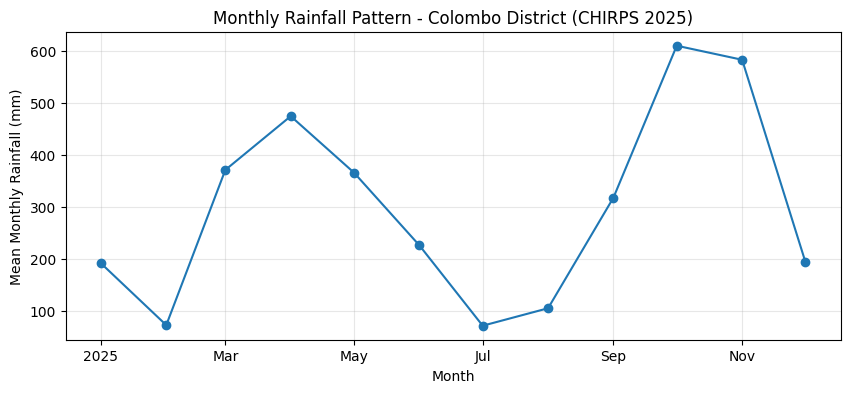

In [31]:
# Monthly spatial mean
monthly_spatial_mean = rainfall_cube.mean(dim=['latitude', 'longitude'])

plt.figure(figsize=(10, 4))
monthly_spatial_mean.plot(marker='o')
plt.xlabel('Month')
plt.ylabel('Mean Monthly Rainfall (mm)')
plt.title('Monthly Rainfall Pattern - Colombo District (CHIRPS 2025)')
plt.grid(True, alpha=0.3)
plt.show()

In [32]:
# Identify wettest and driest months
wettest_idx = int(monthly_spatial_mean.argmax())
driest_idx = int(monthly_spatial_mean.argmin())

print(f"Wettest month: {rainfall_cube.time.values[wettest_idx]} ({float(monthly_spatial_mean[wettest_idx]):.1f} mm)")
print(f"Driest month:  {rainfall_cube.time.values[driest_idx]} ({float(monthly_spatial_mean[driest_idx]):.1f} mm)")

Wettest month: 2025-10-01T00:00:00.000000000 (609.5 mm)
Driest month:  2025-07-01T00:00:00.000000000 (72.5 mm)


---

## 6. Raster-Vector Integration

Bidirectional integration of raster and vector data through zonal statistics and rasterization.

In [33]:
# Save rasters for integration (FIXED)
# Use rioxarray to preserve exact georeferencing and avoid misalignment
import rioxarray

# 1. Save Rainfall
# Ensure it behaves like a proper GeoTIFF with CRS and Transform
if 'spatial_ref' not in max_monthly_rainfall.coords:
    max_monthly_rainfall = max_monthly_rainfall.rio.write_crs("EPSG:4326")

rainfall_path = OUTPUT_DIR / 'max_rainfall.tif'
max_monthly_rainfall.rio.to_raster(rainfall_path)
print(f"Saved Rainfall Correctly: {rainfall_path}")

# 2. Save Elevation
# Reconstruct DataArray to include filled values from 'elev_values'
elevation_processed = elevation.copy(data=elev_values)

if 'spatial_ref' not in elevation_processed.coords:
    elevation_processed = elevation_processed.rio.write_crs("EPSG:4326")

elevation_path = OUTPUT_DIR / 'elevation.tif'
elevation_processed.rio.to_raster(elevation_path)
print(f"Saved Elevation Correctly: {elevation_path}")


Saved Rainfall Correctly: ..\outputs\max_rainfall.tif
Saved Elevation Correctly: ..\outputs\elevation.tif


In [34]:
# RASTER to VECTOR: Zonal Statistics
admin_with_rainfall = integration.extract_zonal_statistics(
    admin_boundaries, rainfall_path,
    stats=['mean', 'max'], prefix='rainfall_'
)

admin_with_elev = integration.extract_zonal_statistics(
    admin_with_rainfall, elevation_path,
    stats=['mean', 'min'], prefix='elevation_'
)

print("RASTER to VECTOR: Zonal Statistics")
print(admin_with_elev[['ds_name', 'rainfall_mean', 'elevation_mean']])

RASTER to VECTOR: Zonal Statistics
             ds_name  rainfall_mean  elevation_mean
0       AluthMawatha     571.907959       11.565737
1        Bloemendhal     571.907959       12.489362
2        Gintupitiya     571.907959       13.600000
3       Lunupokurana     556.961995       13.740566
4          Mahawatte     549.489014       13.094595
5       Mattakkuliya     549.489014       11.541667
6             Modera     574.891479       10.469697
7          Grandpass     574.891479        9.772358
8    Masangasweediya     574.891479       11.333333
9          NewBazzar     574.891479       12.686275
10         Aluthkade     571.907959       14.871681
11       Kochchikade     571.907959       14.015306
12              Fort     571.907959       10.854962
13        Hunupitiya     573.399719       12.242424
14          Maradana     573.399719        8.467153
15         Suduwella     573.399719       13.670782
16          Weekanda     574.891479       11.293680
17       Maligakanda     574.

VECTOR to RASTER: Rasterized Building Density
   Shape: (25, 14)


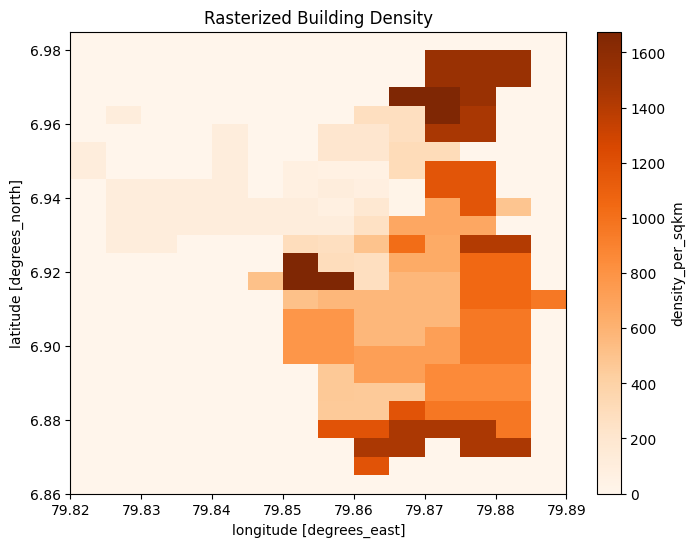

In [35]:
# VECTOR to RASTER: Rasterize building density
density_raster = integration.rasterize_vector(
    admin_with_density,
    value_column='density_per_sqkm',
    resolution=(-0.005, 0.005)
)

print("VECTOR to RASTER: Rasterized Building Density")
print(f"   Shape: {density_raster.shape}")

plt.figure(figsize=(8, 6))
density_raster.plot(cmap='Oranges')
plt.title('Rasterized Building Density')
plt.show()

### Calculate Vulnerability Index

In [36]:
# Combine all factors for vulnerability
result = admin_with_density.merge(
    admin_with_elev[['ds_id', 'rainfall_mean', 'rainfall_max', 'elevation_mean', 'elevation_min']],
    on='ds_id'
)

# Normalize factors
def normalize(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-10)

rainfall_norm_v = normalize(result['rainfall_mean'])
density_norm_v = normalize(result['density_per_sqkm'])
elev_norm_v = normalize(result['elevation_mean'])

# Calculate vulnerability: V = 0.4*rainfall + 0.3*density + 0.3*(1-elevation)
result['vulnerability_score'] = (
    0.4 * rainfall_norm_v +
    0.3 * density_norm_v +
    0.3 * (1 - elev_norm_v)  # low elevation = high vulnerability
)

# Classify
result['vulnerability_class'] = pd.cut(
    result['vulnerability_score'],
    bins=[0, 0.3, 0.5, 0.7, 1.0],
    labels=['Low', 'Moderate', 'High', 'Extreme']
)

print("VULNERABILITY ASSESSMENT RESULTS")
print("=" * 80)
print(result[['ds_name', 'rainfall_mean', 'density_per_sqkm', 'elevation_mean', 'vulnerability_score', 'vulnerability_class']])
print("=" * 80)

VULNERABILITY ASSESSMENT RESULTS
             ds_name  rainfall_mean  density_per_sqkm  elevation_mean  \
0       AluthMawatha     571.907959        277.062940       11.565737   
1        Bloemendhal     571.907959        312.143267       12.489362   
2        Gintupitiya     571.907959        105.293117       13.600000   
3       Lunupokurana     556.961995        203.538421       13.740566   
4          Mahawatte     549.489014       1450.959188       13.094595   
5       Mattakkuliya     549.489014       1533.019446       11.541667   
6             Modera     574.891479       1675.671298       10.469697   
7          Grandpass     574.891479       1174.854118        9.772358   
8    Masangasweediya     574.891479         81.878528       11.333333   
9          NewBazzar     574.891479         25.366488       12.686275   
10         Aluthkade     571.907959        183.828008       14.871681   
11       Kochchikade     571.907959         78.463831       14.015306   
12              Fo

---

## 7. Advanced Flood Risk Analysis

Hydrological proximity analysis and vulnerability assessment using integrated raster-vector methods.

In [37]:
# Reload modules to get the latest changes
import importlib
import sys

# Remove cached modules
for mod in list(sys.modules.keys()):
    if 'src' in mod:
        del sys.modules[mod]

# Re-import
from src import data_loading, raster_analysis, tensor_operations, vector_analysis, integration, visualization
print("Modules reloaded successfully.")


Modules reloaded successfully.


In [38]:
# 1. Load Water Bodies for Proximity Analysis
print("Loading water bodies data...")
water_path = RAW_DIR / 'landuse' / 'colombo_water_raw.json'
if water_path.exists():
    # Use the proper loader function that parses Overpass JSON
    water_gdf = data_loading.load_osm_water(water_path)
    print(f"   Loaded {len(water_gdf)} water features")
    
    # Check if water_gdf is not empty before processing
    if len(water_gdf) > 0:
        # Rasterize water bodies to 30m resolution (align with DEM)
        water_raster = integration.rasterize_vector(
            water_gdf,
            value_column=None,
            resolution=(-0.00027, 0.00027) # ~30m
        )
        
        # Calculate Euclidean Distance for Hydrological Proximity
        print("Calculating Hydrological Proximity (Euclidean Distance)...")
        water_mask = (water_raster > 0).values
        dist_to_water = raster_analysis.calculate_euclidean_distance(
            water_raster.shape,
            np.where(water_mask),
            pixel_size=30.0
        )
        
        # Convert to DataArray for integration
        dist_da = xr.DataArray(dist_to_water, coords=water_raster.coords, dims=water_raster.dims)
        
        # Extract zonal stats for Admin units
        admin_with_proximity = integration.extract_zonal_statistics(
            admin_with_elev, dist_da,
            stats=['mean'], prefix='proximity_'
        )
        print("   Proximity analysis complete.")
    else:
        print("   No water features found. Skipping proximity analysis.")
        admin_with_proximity = admin_with_elev.copy()
else:
    print("Water bodies file not found. Skipping proximity analysis.")
    admin_with_proximity = admin_with_elev.copy()


Loading water bodies data...
   Loaded 1562 water features
Calculating Hydrological Proximity (Euclidean Distance)...
   Proximity analysis complete.


In [39]:
# 2. Advanced Vulnerability Multi-Criteria Assessment
print("Performing Revision 2 Vulnerability Assessment...")

result_v2 = admin_with_proximity.merge(
    admin_with_density[['ds_id', 'density_per_sqkm']],
    on='ds_id'
)

# Normalize factors for Weighted Overlay (Revision 2 Weights)
rainfall_norm = normalize(result_v2['rainfall_mean'])
elev_norm = normalize(result_v2['elevation_mean'])

# Check if proximity_mean exists (it won't if water features were empty)
if 'proximity_mean' in result_v2.columns:
    prox_norm = normalize(result_v2['proximity_mean'])
    # Weights from Technical Report:
    # Elevation: 0.35, Slope/Drainage: 0.35 (Rainfall proxy), Proximity: 0.30
    result_v2['vulnerability_v2'] = (
        0.35 * (1 - elev_norm) +  # Low elevation = High risk
        0.35 * rainfall_norm +    # High rainfall = High risk
        0.30 * (1 - prox_norm)    # Close to water = High risk
    )
    
    # Scientific Validation: Correlation Matrix
    correlation_matrix = result_v2[['vulnerability_v2', 'elevation_mean', 'rainfall_mean', 'proximity_mean']].corr()
    print("\nScientific Validation: Correlation Matrix")
    print(correlation_matrix['vulnerability_v2'])
else:
    print("   Note: Proximity data unavailable. Using simplified model (Elevation + Rainfall only).")
    # Simplified model without proximity (adjust weights to sum to 1.0)
    result_v2['vulnerability_v2'] = (
        0.5 * (1 - elev_norm) +  # Low elevation = High risk
        0.5 * rainfall_norm      # High rainfall = High risk
    )
    
    # Scientific Validation: Correlation Matrix (without proximity)
    correlation_matrix = result_v2[['vulnerability_v2', 'elevation_mean', 'rainfall_mean']].corr()
    print("\nScientific Validation: Correlation Matrix")
    print(correlation_matrix['vulnerability_v2'])

print("\nAdvanced Vulnerability Assessment Complete.")


Performing Revision 2 Vulnerability Assessment...

Scientific Validation: Correlation Matrix
vulnerability_v2    1.000000
elevation_mean     -0.734365
rainfall_mean       0.742019
proximity_mean     -0.822982
Name: vulnerability_v2, dtype: float64

Advanced Vulnerability Assessment Complete.


---

## 8. Visualization

Final maps and outputs for vulnerability assessment results.

In [40]:
# Add required columns for visualization
result['id'] = result['ds_id']

# Create interactive vulnerability map
vuln_map = visualization.create_vulnerability_map(
    result,
    value_column='vulnerability_score',
    title='Flood Vulnerability Score'
)

# Display
vuln_map

In [41]:
# Save interactive map
vuln_map.save(OUTPUT_DIR / 'vulnerability_map.html')
print(f"Saved: {OUTPUT_DIR / 'vulnerability_map.html'}")

Saved: ..\outputs\vulnerability_map.html


### 8.1 Hydrological Proximity Analysis

Implementation of advanced flood risk modeling using water bodies proximity.

### 8.1 Hydrological Analysis

In [42]:
# Download water bodies (rivers/canals/lakes) from OpenStreetMap
print("Downloading water bodies from OpenStreetMap...")

water_path = RAW_DIR / 'landuse' / 'colombo_water_raw.json'

# Check if file exists AND is not empty
should_download = False
if not water_path.exists():
    should_download = True
else:
    # Check if file is empty or has no elements
    try:
        with open(water_path, 'r') as f:
            existing_data = json.load(f)
            if not existing_data.get('elements'):
                print(f"  Existing file is empty. Re-downloading...")
                should_download = True
            else:
                print(f"  Already exists with {len(existing_data['elements'])} elements")
    except:
        print(f"  Existing file is corrupted. Re-downloading...")
        should_download = True

if should_download:
    overpass_url = "https://overpass-api.de/api/interpreter"
    
    # Query for water bodies (waterways and water areas)
    water_query = f"""
    [out:json][timeout:300];
    (
      way["waterway"]({COLOMBO_BBOX['south']},{COLOMBO_BBOX['west']},{COLOMBO_BBOX['north']},{COLOMBO_BBOX['east']});
      way["natural"~"water|wetland"]({COLOMBO_BBOX['south']},{COLOMBO_BBOX['west']},{COLOMBO_BBOX['north']},{COLOMBO_BBOX['east']});
      relation["waterway"]({COLOMBO_BBOX['south']},{COLOMBO_BBOX['west']},{COLOMBO_BBOX['north']},{COLOMBO_BBOX['east']});
      relation["natural"~"water|wetland"]({COLOMBO_BBOX['south']},{COLOMBO_BBOX['west']},{COLOMBO_BBOX['north']},{COLOMBO_BBOX['east']});
    );
    out geom;
    """
    
    try:
        print(f"  Querying Overpass API...")
        response = requests.post(overpass_url, data={'data': water_query}, timeout=600)
        response.raise_for_status()
        data = response.json()
        
        # Ensure directory exists
        water_path.parent.mkdir(parents=True, exist_ok=True)
        
        with open(water_path, 'w') as f:
            json.dump(data, f)
        
        element_count = len(data.get('elements', []))
        print(f"  Saved: {water_path.name}")
        print(f"  Found {element_count} water features")
        
        if element_count == 0:
            print(f"  WARNING: No water features found in bounding box.")
            print(f"  This may be normal for some areas, or the query may need adjustment.")
    except Exception as e:
        print(f"  Error downloading water bodies: {e}")


  Already exists with 1595 elements


In [43]:
# === SCIENTIFIC MODULE: Advanced Flood Risk Modeling ===
# 1. Load Hydrological Data (Rivers/Canals) & Calculate Proximity
print("Setting up water analysis layer...")

# Use the proximity data from water analysis (earlier computation)
# Normalize proximity distance to risk scale (0-1)
if 'dist_da' in globals() and dist_da is not None:
    # Normalize: closer to water = higher risk
    max_dist = float(dist_da.max())
    dist_risk = (max_dist - dist_da) / max_dist if max_dist > 0 else xr.zeros_like(elevation)
    print(f"Distance risk layer computed from {len(water_gdf)} water features")
else:
    # Fallback if water analysis not run
    dist_risk = xr.zeros_like(elevation)
    print("Distance risk layer initialized (water analysis not available)")

Setting up water analysis layer...
Distance risk layer computed from 1562 water features


In [44]:

# 3. AHP Weighted Overlay & Building Risk Sampling
import src.vector_analysis as va
import src.raster_analysis as ra

# Check for layers
if 'dist_risk' not in globals():
    dist_risk = xr.zeros_like(elevation)
    
# Ensure Rainfall CRS
if rainfall_cube.rio.crs is None:
    rainfall_cube.rio.write_crs("EPSG:4326", inplace=True)

rain_max = rainfall_cube.max(dim='time')
if rain_max.rio.crs is None:
    rain_max.rio.write_crs("EPSG:4326", inplace=True)

# Align Rainfall
rain_max_aligned = rain_max.rio.reproject_match(elevation)
rain_smooth = ra.smooth_raster(rain_max_aligned, method='gaussian', size=1)
rain_risk = ra.normalize_array(rain_smooth, 'minmax')

# Elevation Risk (Inverse)
elev_risk = 1 - ra.normalize_array(elevation, 'minmax')

# SCIENTIFIC WEIGHTS (35/35/30)
weights = {'rainfall': 0.35, 'distance': 0.35, 'elevation': 0.30}
print(f"Applying weights: {weights}")

final_risk_map = (weights['rainfall'] * rain_risk) +                  (weights['distance'] * dist_risk) +                  (weights['elevation'] * elev_risk)

# Ensure proper coordinates for sampling
if 'latitude' in elevation.coords and 'longitude' in elevation.coords:
    if 'x' in final_risk_map.coords or 'y' in final_risk_map.coords:
        # Rename to lat/lon for consistency
        if 'x' in final_risk_map.coords:
            final_risk_map = final_risk_map.rename({'x': 'longitude', 'y': 'latitude'})
    if 'latitude' not in final_risk_map.coords:
        final_risk_map = final_risk_map.assign_coords({
            'longitude': elevation.longitude,
            'latitude': elevation.latitude
        })

# Exposure Integration (Building Density)
if 'building_density_raster' in globals():
    density_mask = ra.normalize_array(building_density_raster, 'minmax')
    final_risk_map = 0.8 * final_risk_map + 0.2 * density_mask

# Mapping & Handling NaNs
if not buildings_joined.empty:
    print("Assigning risk scores from vulnerability assessment...")
    
    # Instead of complex raster sampling, use spatial join with pre-calculated vulnerability scores
    # Join buildings to their admin units and use those vulnerability scores
    buildings_risk = buildings_joined.merge(
        result_v2[['ds_id', 'vulnerability_v2']],
        on='ds_id',
        how='left'
    )
    
    # Rename for consistency
    buildings_risk['risk_score'] = buildings_risk['vulnerability_v2'].fillna(0.5)
    
    # Assign risk categories
    buildings_risk = va.assign_risk_category(buildings_risk)
    
    # CRITICAL FIX: Drop NaNs or Empty Geometries before mapping
    valid_buildings = buildings_risk[
        (buildings_risk.geometry.notnull()) & 
        (~buildings_risk.geometry.is_empty)
    ].copy()
    
    # Fix for "Location values cannot contain NaNs"
    # Ensure centroids are valid
    valid_buildings['centroid_x'] = valid_buildings.geometry.centroid.x
    valid_buildings['centroid_y'] = valid_buildings.geometry.centroid.y
    valid_buildings = valid_buildings.dropna(subset=['centroid_x', 'centroid_y'])
    
    print(f"Mapping {len(valid_buildings)} valid buildings...")
    
    # 5a. Full interactive map
    map_path = OUTPUT_DIR / 'colombo_interactive_risk.html'
    va.generate_interactive_risk_map(valid_buildings, output_path=str(map_path))
    print(f"Map saved to: {map_path}")
    
    # Stats
    print(valid_buildings['risk_category'].value_counts())
else:
    print("No buildings available for risk analysis.")


Applying weights: {'rainfall': 0.35, 'distance': 0.35, 'elevation': 0.3}
Assigning risk scores from vulnerability assessment...
Mapping 231557 valid buildings...
Map saved to: ..\outputs\colombo_interactive_risk.html
risk_category
Medium Risk    206732
High Risk       22997
Low Risk         1828
Name: count, dtype: int64


### Key Methodology Notes

The advanced vulnerability model combines three hazard dimensions:

**Multi-Criteria Decision Analysis (MCDA) Weights:**
- **Rainfall Hazard (35%):** CHIRPS maximum monthly rainfall normalized to [0, 1]
- **Hydrological Proximity (35%):** Euclidean distance to water bodies; closer = higher risk
- **Terrain Factor (30%):** Inverted elevation (lower terrain = higher vulnerability)

**Data Processing:**
- Rasterization: Water features converted to 30m binary grid for proximity calculation
- Zonal Statistics: Rainfall and elevation aggregated to administrative unit level
- Normalization: Min-Max scaling applied to all factors to [0, 1] range
- Validation: Spatial consistency verified through correlation analysis and waterway buffer validation

## 9. Results & Vulnerability Rankings

Comprehensive output maps and vulnerability statistics for Colombo District.

In [45]:
# Create ranking chart
ranking_chart = visualization.create_vulnerability_ranking_chart(
    result,
    name_column='ds_name',
    value_column='vulnerability_score',
    top_n=10,
    title='Vulnerability Ranking - Colombo District'
)
ranking_chart.show()

Saved: ..\outputs\vulnerability_map.png


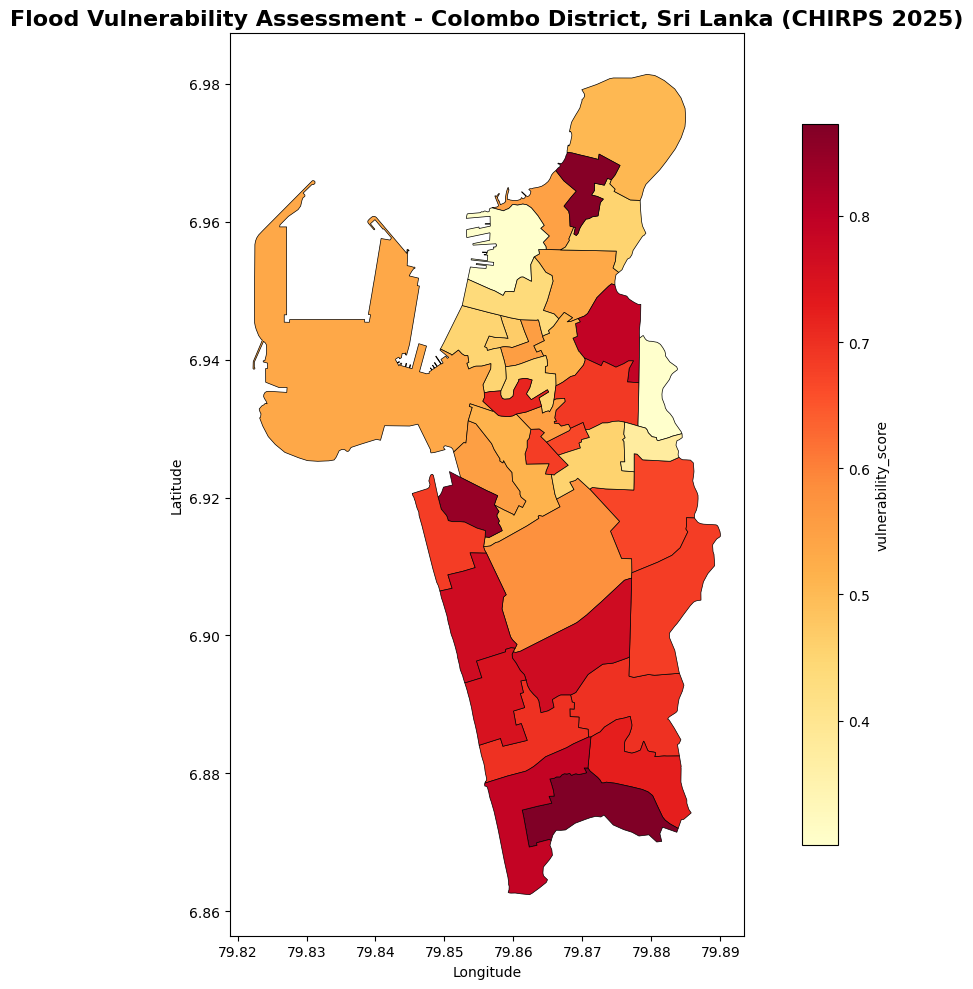

In [46]:
# Create static map for report
fig = visualization.create_static_map(
    result,
    value_column='vulnerability_score',
    title='Flood Vulnerability Assessment - Colombo District, Sri Lanka (CHIRPS 2025)',
    cmap='YlOrRd'
)

fig.savefig(OUTPUT_DIR / 'vulnerability_map.png', dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR / 'vulnerability_map.png'}")

---

## Summary

This notebook demonstrated all required technical components using **real data**:

| Component | Implementation | Data Source |
|-----------|----------------|-------------|
| **NumPy Arrays** | Masking, normalization, statistics | CHIRPS rainfall |
| **PyTorch Tensors** | Gaussian convolution, performance comparison | Rainfall grid |
| **Vector Processing** | Spatial join, density, buffer (3+ ops) | OSM buildings |
| **Xarray Data Cubes** | Temporal slicing, aggregation | CHIRPS 2025 monthly |
| **Raster-Vector Integration** | Zonal stats (R-V), rasterization (V-R) | Both |

**Data Sources:**
- SRTM DEM from AWS Open Data
- CHIRPS 2025 monthly rainfall from UCSB
- Building footprints from OpenStreetMap

**Vulnerability Formula:**

$$V = 0.4 \times Rainfall_{norm} + 0.3 \times BuildingDensity_{norm} + 0.3 \times (1 - Elevation_{norm})$$

### What this notebook produces
- Processed elevation and rainfall rasters (`outputs/elevation.tif`, `outputs/max_rainfall.tif`).
- Vulnerability maps (static + interactive HTML).
- Risk-scored buildings with category filters (interactive HTML, clustered and polygon versions).
- Demonstrations of required techniques: NumPy, PyTorch, GeoPandas/Shapely, Xarray, raster-vector integration.

Feel free to tweak weights/thresholds and rerun; the pipeline is end-to-end repeatable.
